In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from pathlib import Path
import pickle
from copy import deepcopy as dcopy

# Modelo Predictivo de puntaje nem a puntaje paes

en esta seccion se creara un modelo regresivo en el cual se busca presentar una herramienta que predisca que puntaje tendra una persona en la paes, a partir de su nem, esto para poder presentar el como estas herramientas pueden ser util tanto para solucionar datos faltantes, como para una prediccion para la ayuda de una persona.

In [92]:
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Config visualizacion
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 1. Carga de Datos

In [93]:
# Años a analizar
años = [2023, 2024, 2025]

# Lista para almacenar dataframes
adm = []

# Cargar datos
for año in años:
    try:
        # Buscar archivos CSV
        ruta = Path(f'raw_data/{año}')
        archivos = list(ruta.glob(f'**/ArchivoC_Adm{año}*.csv'))
        
        if archivos:
            df = pd.read_csv(archivos[0], sep=';', low_memory=False)
            df['ANIO'] = año
            adm.append(df)
            print(f"✓ Datos {año} cargados: {df.shape[0]} registros")
        else:
            print(f"✗ No se encontraron archivos para {año}")
    except Exception as e:
        print(f"Error cargando {año}: {e}")

# Verificar
print(f"\nTotal dataframes cargados: {len(adm)}")

✓ Datos 2023 cargados: 293865 registros
✓ Datos 2024 cargados: 306497 registros
✓ Datos 2025 cargados: 311084 registros

Total dataframes cargados: 3


In [94]:
with open('pkl-data/adm_lista.pkl', 'rb') as lectura:
    adm = pickle.load(lectura)

In [95]:
# Concatenar todos los años
if len(adm) > 0:
    df_completo = pd.concat(adm, ignore_index=True)
    print(f"Dataset completo: {df_completo.shape}")
    df_completo.head()

Dataset completo: (5455237, 60)


## limpieza de las variables

In [96]:
# Seleccionar columnas relevantes: MATE1_INV_ACTUAL, CLEC_INV_ACTUAL, PTJE_NEM
columnas = ['ID_aux', 'MATE1_INV_ACTUAL', 'CLEC_INV_ACTUAL', 'PTJE_NEM', 'ANIO']

# Verificar que existan las columnas
columnas_disponibles = [col for col in columnas if col in df_completo.columns]
print(f"Columnas disponibles: {columnas_disponibles}")

# Crear dataset de trabajo
df = df_completo[columnas_disponibles].copy()

# Info inicial
print(f"\nDatos antes de limpieza: {df.shape}")
df.info()

Columnas disponibles: ['ID_aux', 'MATE1_INV_ACTUAL', 'CLEC_INV_ACTUAL', 'PTJE_NEM']

Datos antes de limpieza: (5455237, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5455237 entries, 0 to 5455236
Data columns (total 4 columns):
 #   Column            Dtype  
---  ------            -----  
 0   ID_aux            object 
 1   MATE1_INV_ACTUAL  float64
 2   CLEC_INV_ACTUAL   float64
 3   PTJE_NEM          int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 166.5+ MB


In [97]:
# Limpieza de datos
# Eliminar nulos
df = df.dropna(subset=['MATE1_INV_ACTUAL', 'CLEC_INV_ACTUAL', 'PTJE_NEM'])

# Convertir a numérico
df['MATE1_INV_ACTUAL'] = pd.to_numeric(df['MATE1_INV_ACTUAL'], errors='coerce')
df['CLEC_INV_ACTUAL'] = pd.to_numeric(df['CLEC_INV_ACTUAL'], errors='coerce')
df['PTJE_NEM'] = pd.to_numeric(df['PTJE_NEM'], errors='coerce')

# Eliminar NaN después de conversión
df = df.dropna(subset=['MATE1_INV_ACTUAL', 'CLEC_INV_ACTUAL', 'PTJE_NEM'])

# Crear variable PROM_PAES (promedio de MATE1 y CLEC)
df['PROM_PAES'] = (df['MATE1_INV_ACTUAL'] + df['CLEC_INV_ACTUAL']) / 2

# Eliminar valores <= 0 o fuera de rango razonable
# Puntajes PAES van de 100 a 1000
df = df[(df['MATE1_INV_ACTUAL'] > 100) & (df['MATE1_INV_ACTUAL'] <= 1000)]
df = df[(df['CLEC_INV_ACTUAL'] > 100) & (df['CLEC_INV_ACTUAL'] <= 1000)]
df = df[(df['PTJE_NEM'] > 0) & (df['PTJE_NEM'] <= 1000)]

# Eliminar outliers extremos (percentil 1% y 99%)
Q1_mate = df['MATE1_INV_ACTUAL'].quantile(0.01)
Q3_mate = df['MATE1_INV_ACTUAL'].quantile(0.99)
Q1_clec = df['CLEC_INV_ACTUAL'].quantile(0.01)
Q3_clec = df['CLEC_INV_ACTUAL'].quantile(0.99)
Q1_ptje = df['PTJE_NEM'].quantile(0.01)
Q3_ptje = df['PTJE_NEM'].quantile(0.99)

df = df[(df['MATE1_INV_ACTUAL'] >= Q1_mate) & (df['MATE1_INV_ACTUAL'] <= Q3_mate)]
df = df[(df['CLEC_INV_ACTUAL'] >= Q1_clec) & (df['CLEC_INV_ACTUAL'] <= Q3_clec)]
df = df[(df['PTJE_NEM'] >= Q1_ptje) & (df['PTJE_NEM'] <= Q3_ptje)]

print(f"Datos después de limpieza: {df.shape}")
print(f"Registros eliminados: {df_completo.shape[0] - df.shape[0]}")
print(f"Porcentaje de datos conservados: {df.shape[0]/df_completo.shape[0]*100:.1f}%")

Datos después de limpieza: (43427, 5)
Registros eliminados: 5411810
Porcentaje de datos conservados: 0.8%


## preparacion de Datos de modelados

In [98]:
x = df[['MATE1_INV_ACTUAL', 'CLEC_INV_ACTUAL']].values
y = df['PTJE_NEM'].values

X_prom = df[['PROM_PAES']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_prom_train, X_prom_test, _, _ = train_test_split(X_prom, y, test_size=0.2, random_state=42)

print(f"Datos de entrenamiento: {X_train.shape}")
print(f"Datos de prueba: {X_test.shape}")
print(f"Features: MATE1_INV_ACTUAL, CLEC_INV_ACTUAL")

Datos de entrenamiento: (34741, 2)
Datos de prueba: (8686, 2)
Features: MATE1_INV_ACTUAL, CLEC_INV_ACTUAL


## Modelos de regresion

Regresión Lineal Múltiple (MATE1 + CLEC)

In [99]:
lr_multiple = LinearRegression()
lr_multiple.fit(X_train, y_train)

y_pred_train_lr = lr_multiple.predict(X_train)
y_pred_test_lr = lr_multiple.predict(X_test)

r2_train_lr = r2_score(y_train, y_pred_train_lr)
r2_test_lr = r2_score(y_test, y_pred_test_lr)
mse_lr = mean_squared_error(y_test, y_pred_test_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_test_lr)

print("=== Regresión Lineal Múltiple (MATE1 + CLEC) ===")
print(f"Coeficiente MATE1: {lr_multiple.coef_[0]:.4f}")
print(f"Coeficiente CLEC: {lr_multiple.coef_[1]:.4f}")
print(f"Intercepto: {lr_multiple.intercept_:.4f}")
print(f"\nEcuación: PTJE_NEM = {lr_multiple.coef_[0]:.4f}*MATE1 + {lr_multiple.coef_[1]:.4f}*CLEC + {lr_multiple.intercept_:.4f}")
print(f"\nR² (train): {r2_train_lr:.4f}")
print(f"R² (test): {r2_test_lr:.4f}")
print(f"MSE: {mse_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")
print(f"MAE: {mae_lr:.4f}")

=== Regresión Lineal Múltiple (MATE1 + CLEC) ===
Coeficiente MATE1: 0.3477
Coeficiente CLEC: 0.2417
Intercepto: 352.3940

Ecuación: PTJE_NEM = 0.3477*MATE1 + 0.2417*CLEC + 352.3940

R² (train): 0.2696
R² (test): 0.2721
MSE: 14067.1285
RMSE: 118.6049
MAE: 96.1780


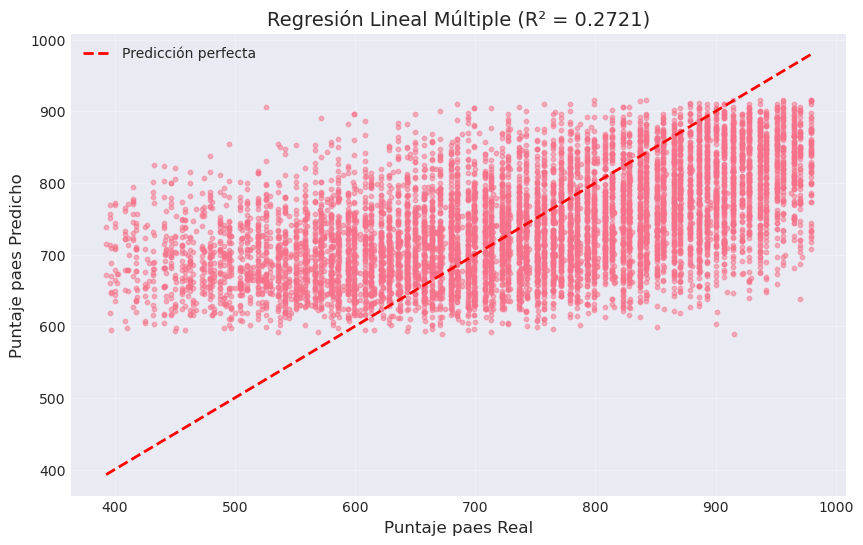

In [100]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test_lr, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Predicción perfecta')
plt.xlabel('Puntaje paes Real', fontsize=12)
plt.ylabel('Puntaje paes Predicho', fontsize=12)
plt.title(f'Regresión Lineal Múltiple (R² = {r2_test_lr:.4f})', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
ruta = os.path.join("graficos-imagenes", 'regresion_lineal_multiple.png')
plt.savefig(ruta)
plt.show()

Regresión Polinomial

In [101]:
grados = [2, 3]
resultados_poly = {}

for grado in grados:
    poly = PolynomialFeatures(degree=grado, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    lr_poly = LinearRegression()
    lr_poly.fit(X_train_poly, y_train)

    y_pred_train_poly = lr_poly.predict(X_train_poly)
    y_pred_test_poly = lr_poly.predict(X_test_poly)
    r2_train = r2_score(y_train, y_pred_train_poly)
    r2_test = r2_score(y_test, y_pred_test_poly)
    mse = mean_squared_error(y_test, y_pred_test_poly)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred_test_poly)
    
    resultados_poly[grado] = {
        'modelo': lr_poly,
        'poly': poly,
        'r2_train': r2_train,
        'r2_test': r2_test,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'y_pred': y_pred_test_poly
    }
    
    print(f"\n=== Regresión Polinomial (Grado {grado}) ===")
    print(f"Features generados: {X_train_poly.shape[1]}")
    print(f"R² (train): {r2_train:.4f}")
    print(f"R² (test): {r2_test:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")


=== Regresión Polinomial (Grado 2) ===
Features generados: 5
R² (train): 0.2697
R² (test): 0.2724
MSE: 14060.5262
RMSE: 118.5771
MAE: 96.1683

=== Regresión Polinomial (Grado 3) ===
Features generados: 9
R² (train): 0.2714
R² (test): 0.2735
MSE: 14039.8142
RMSE: 118.4897
MAE: 96.0576


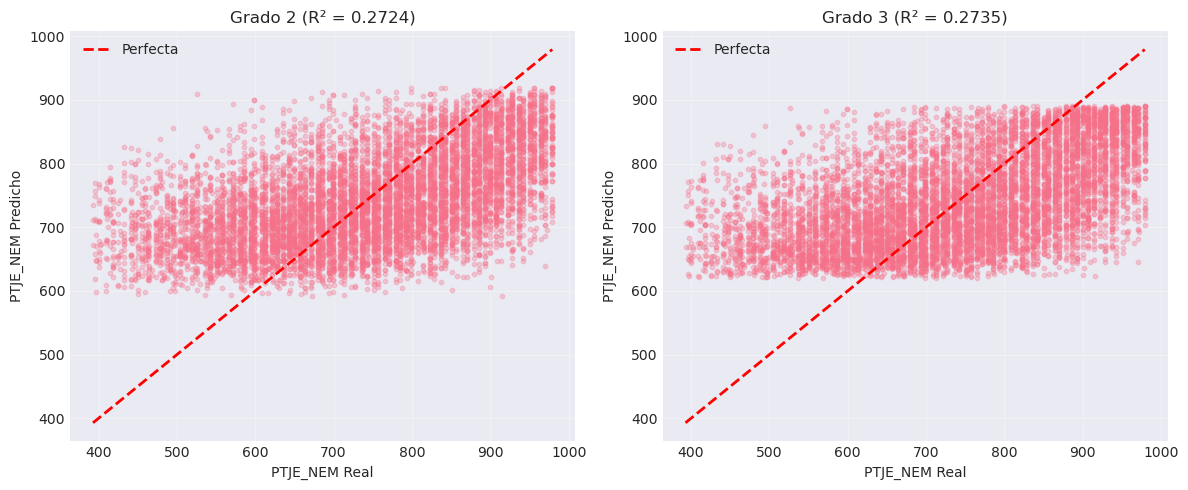

In [109]:
fig, axes = plt.subplots(1, len(grados), figsize=(12, 5))

for idx, grado in enumerate(grados):
    y_pred_poly = resultados_poly[grado]['y_pred']

    axes[idx].scatter(y_test, y_pred_poly, alpha=0.3, s=10)
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                   'r--', lw=2, label='Perfecta')
    axes[idx].set_xlabel('PTJE_NEM Real')
    axes[idx].set_ylabel('PTJE_NEM Predicho')
    axes[idx].set_title(f'Grado {grado} (R² = {resultados_poly[grado]["r2_test"]:.4f})')
    axes[idx].legend()
    ruta = os.path.join("graficos-imagenes", "regresion_polinomial.png")
    plt.savefig(ruta)
    
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [103]:
# Normalizar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Probar diferentes alphas
alphas = [0.1, 1.0, 10.0, 100.0]
resultados_ridge = {}

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    
    y_pred_train_ridge = ridge.predict(X_train_scaled)
    y_pred_test_ridge = ridge.predict(X_test_scaled)
    
    r2_train = r2_score(y_train, y_pred_train_ridge)
    r2_test = r2_score(y_test, y_pred_test_ridge)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_ridge))
    
    resultados_ridge[alpha] = {
        'r2_train': r2_train,
        'r2_test': r2_test,
        'rmse': rmse
    }
    
    print(f"Alpha={alpha}: R² train={r2_train:.4f}, R² test={r2_test:.4f}, RMSE={rmse:.4f}")

Alpha=0.1: R² train=0.2696, R² test=0.2721, RMSE=118.6049
Alpha=1.0: R² train=0.2696, R² test=0.2721, RMSE=118.6049
Alpha=10.0: R² train=0.2696, R² test=0.2721, RMSE=118.6050
Alpha=100.0: R² train=0.2696, R² test=0.2721, RMSE=118.6054


In [104]:
# Probar diferentes alphas
resultados_lasso = {}

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_scaled, y_train)
    
    y_pred_train_lasso = lasso.predict(X_train_scaled)
    y_pred_test_lasso = lasso.predict(X_test_scaled)
    
    r2_train = r2_score(y_train, y_pred_train_lasso)
    r2_test = r2_score(y_test, y_pred_test_lasso)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_lasso))
    
    resultados_lasso[alpha] = {
        'r2_train': r2_train,
        'r2_test': r2_test,
        'rmse': rmse
    }
    
    print(f"Alpha={alpha}: R² train={r2_train:.4f}, R² test={r2_test:.4f}, RMSE={rmse:.4f}")

Alpha=0.1: R² train=0.2696, R² test=0.2721, RMSE=118.6061
Alpha=1.0: R² train=0.2695, R² test=0.2719, RMSE=118.6210
Alpha=10.0: R² train=0.2632, R² test=0.2645, RMSE=119.2235
Alpha=100.0: R² train=0.0000, R² test=-0.0001, RMSE=139.0183


comparacion de modelos


=== COMPARACIÓN DE MODELOS ===
            Modelo  R² Train  R² Test       RMSE       MAE
Polinomial Grado 3  0.271386 0.273479 118.489722 96.057567
Polinomial Grado 2  0.269701 0.272408 118.577090 96.168291
   Lineal Múltiple  0.269574 0.272066 118.604926 96.178043


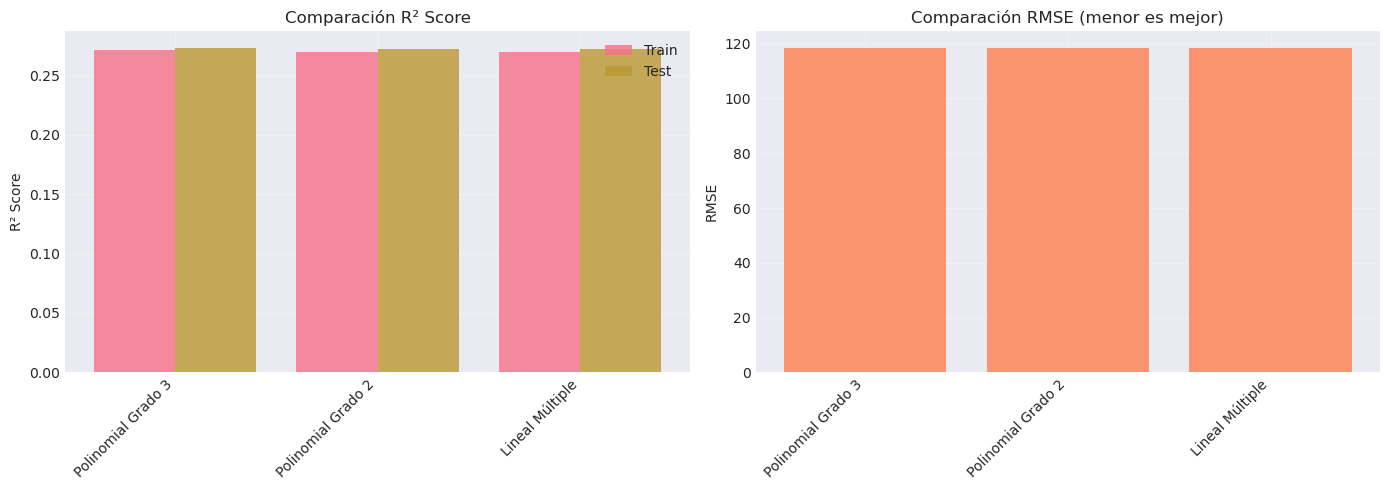

In [105]:
modelos_lista = ['Lineal Múltiple']
r2_train_lista = [r2_train_lr]
r2_test_lista = [r2_test_lr]
rmse_lista = [rmse_lr]

mae_lista = [mae_lr]

for grado in grados:
    modelos_lista.append(f'Polinomial Grado {grado}')
    r2_train_lista.append(resultados_poly[grado]['r2_train'])
    r2_test_lista.append(resultados_poly[grado]['r2_test'])
    rmse_lista.append(resultados_poly[grado]['rmse'])
    mae_lista.append(resultados_poly[grado]['mae'])

comparacion = pd.DataFrame({
    'Modelo': modelos_lista,
    'R² Train': r2_train_lista,
    'R² Test': r2_test_lista,
    'RMSE': rmse_lista,
    'MAE': mae_lista
})

comparacion = comparacion.sort_values('R² Test', ascending=False)
print("\n=== COMPARACIÓN DE MODELOS ===")
print(comparacion.to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
x_pos = np.arange(len(comparacion))
axes[0].bar(x_pos - 0.2, comparacion['R² Train'], 0.4, label='Train', alpha=0.8)
axes[0].bar(x_pos + 0.2, comparacion['R² Test'], 0.4, label='Test', alpha=0.8)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparacion['Modelo'], rotation=45, ha='right')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Comparación R² Score')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].bar(x_pos, comparacion['RMSE'], alpha=0.8, color='coral')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(comparacion['Modelo'], rotation=45, ha='right')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Comparación RMSE (menor es mejor)')
axes[1].grid(True, alpha=0.3)
ruta = os.path.join("graficos-imagenes", 'Comparacion_modelos.png')
plt.savefig(ruta)

plt.tight_layout()
plt.show()

In [106]:
mejor_modelo_nombre = comparacion.iloc[0]['Modelo']
print(f"Mejor modelo: {mejor_modelo_nombre}")

if 'Múltiple' in mejor_modelo_nombre:
    y_pred_mejor = y_pred_test_lr
    mejor_modelo = lr_multiple
else:
    grado_mejor = int(mejor_modelo_nombre.split()[-1])
    y_pred_mejor = resultados_poly[grado_mejor]['y_pred']
    mejor_modelo = resultados_poly[grado_mejor]['modelo']
    
residuos = y_test - y_pred_mejor


Mejor modelo: Polinomial Grado 3


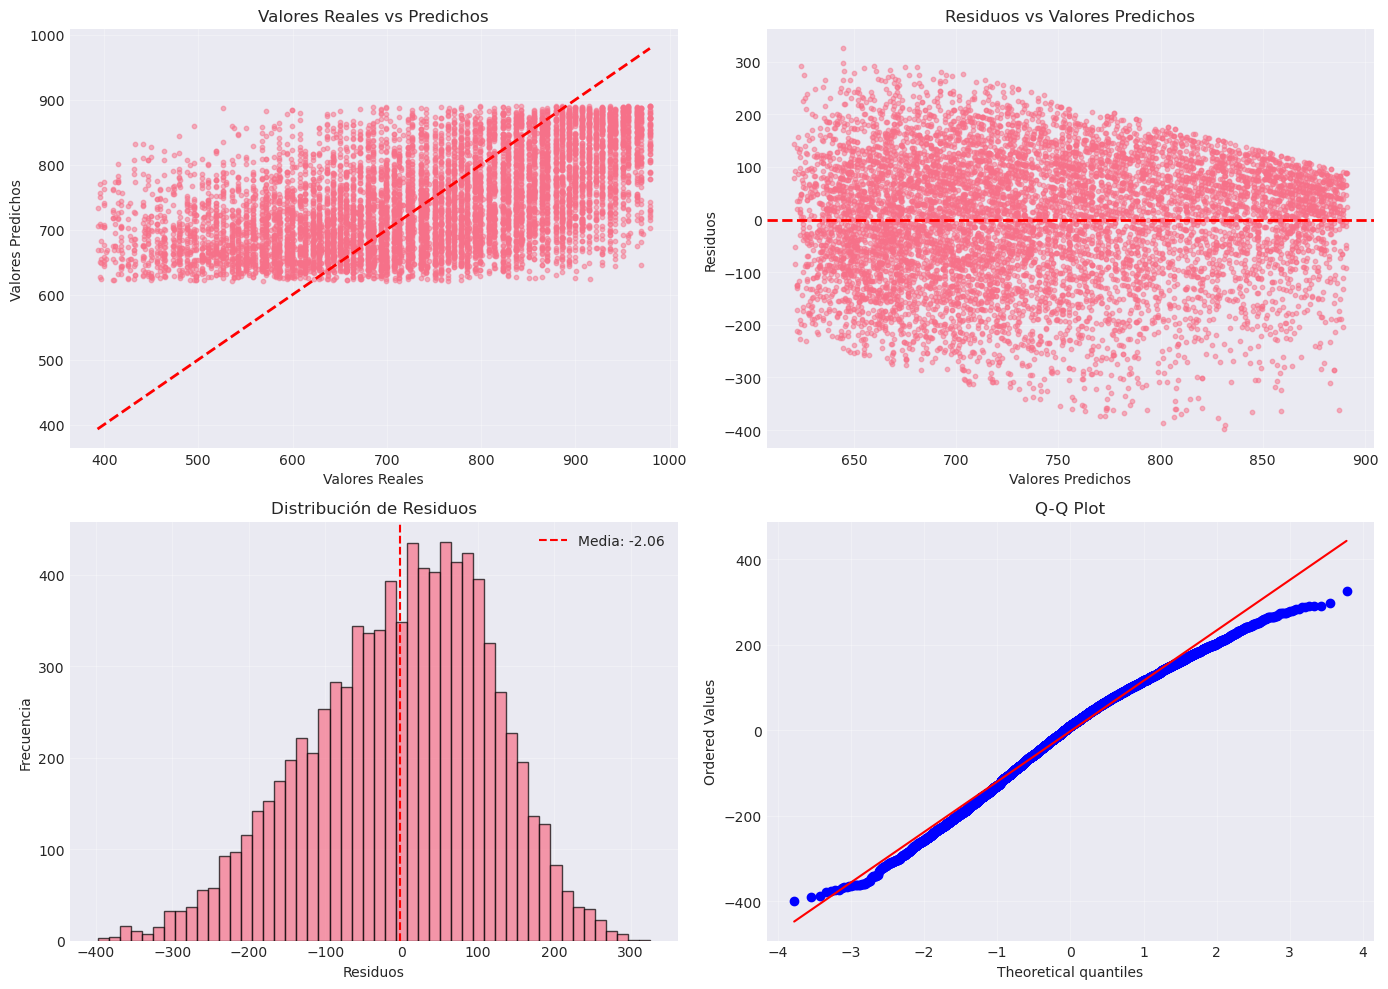


=== ESTADÍSTICAS DE RESIDUOS ===
Media: -2.0589
Desviación estándar: 118.4718
Min: -398.1179
Max: 325.1937


In [107]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].scatter(y_test, y_pred_mejor, alpha=0.5, s=10)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Valores Reales')
axes[0, 0].set_ylabel('Valores Predichos')
axes[0, 0].set_title('Valores Reales vs Predichos')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(y_pred_mejor, residuos, alpha=0.5, s=10)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Valores Predichos')
axes[0, 1].set_ylabel('Residuos')
axes[0, 1].set_title('Residuos vs Valores Predichos')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(residuos, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residuos')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_title('Distribución de Residuos')
axes[1, 0].axvline(residuos.mean(), color='r', linestyle='--', label=f'Media: {residuos.mean():.2f}')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

from scipy import stats
stats.probplot(residuos, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
ruta = os.path.join("graficos-imagenes", 'estadisticas_residuos.png')
plt.savefig(ruta)
plt.show()

print("\n=== ESTADÍSTICAS DE RESIDUOS ===")
print(f"Media: {residuos.mean():.4f}")
print(f"Desviación estándar: {residuos.std():.4f}")
print(f"Min: {residuos.min():.4f}")
print(f"Max: {residuos.max():.4f}")

In [108]:
ejemplos = np.array([
    [400, 400],  # Bajo
    [500, 500],  # Medio-Bajo
    [600, 600],  # Medio
    [700, 700],  # Medio-Alto
    [800, 800],  # Alto
    [600, 700],  # MATE bajo, CLEC alto
    [700, 600]   # MATE alto, CLEC bajo
])

print("\n=== PREDICCIONES DE EJEMPLO ===")
print(f"Usando modelo: {mejor_modelo_nombre}\n")

if 'Múltiple' in mejor_modelo_nombre:
    predicciones = lr_multiple.predict(ejemplos)
else:
    grado_mejor = int(mejor_modelo_nombre.split()[-1])
    ejemplos_poly = resultados_poly[grado_mejor]['poly'].transform(ejemplos)
    predicciones = resultados_poly[grado_mejor]['modelo'].predict(ejemplos_poly)

print(f"{'MATE1':<8} {'CLEC':<8} {'Prom nem':<12} → {'Puntaje paes Predicho':<20}")
print("="*60)
for (mate, clec), pred in zip(ejemplos, predicciones):
    prom_paes = (mate + clec) / 2
    print(f"{mate:<8.0f} {clec:<8.0f} {prom_paes:<12.1f} → {pred:<20.2f}")


=== PREDICCIONES DE EJEMPLO ===
Usando modelo: Polinomial Grado 3

MATE1    CLEC     Prom nem     → Puntaje paes Predicho
400      400      400.0        → 624.70              
500      500      500.0        → 649.37              
600      600      600.0        → 701.81              
700      700      700.0        → 767.27              
800      800      800.0        → 831.03              
600      700      650.0        → 726.66              
700      600      650.0        → 740.00              
